# TP2: Estimación de peso y dimensiones de los envíos de Mercado Libre

# Materia: Análisis y curación de datos

## Análisis del dataset

Se pide: A partir de lo visto en la teoría de la materia y del segundo laboratorio, diagramar una comunicación en formato textual o interactivo describiendo la solución de las actividades propuestas a continuación. Al final de las mismas se proveen actividades opcionales (no obligatorias) que pueden resultar de interés.

### Actividades Propuestas:
    1.	Eliminar valores cuyo status sea `404` , luego eliminar la columna `status` del dataset ya que solo es útil para limpieza.

    2.	Eliminar los valores NaN de las columnas con prefijo `SHP_`. Estas son aquellas que representan o peso o dimensiones de un item.

    3.	Agrupar por item id y calcular mediana de peso y medidas. De esta forma debería quedar una única fila por cada item_id.

    4.	Parsear la columna de atributos y extraer a columnas propias aquellos atributos cuyo `id` sea `BRAND` o `MODEL`. Estos atributos representan marca o modelo que el vendedor del item ingresó en la publicación. [Opcional] No es necesario limitarse a estos dos atributos, se puede probar quedarse con los N atributos más frecuentes.

    5.	Transformar variables categóricas en números (Se recomienda OneHotEncoding) para las columnas (Sugerencia: arrancar con un sample de ~10K items)

        a.	`CATALOG_PRODUCT_ID`
        b.	`CONDITION`
        c.	`DOMAIN_ID`
        d.	`SELLER_ID`
        e.	`BRAND` (extraída en 4)
        f.	`MODEL`(extraída en 4)

    6.	En caso de tener alguna variable no medida (en nuestro caso `PRICE`) imputar sus valores utilizando kNN.

    7.	Medir las distribuciones de las variables como histogramas, realizar normalizaciones e identificar outliers con los métodos vistos en clase. Hacer análisis de estos outliers y considerar si sería correcto o no eliminarlos del dataset. Sugerencia: Identificar outliers de las columnas `SHP_WEIGHT` y `SHP_VOLUME`, donde `SHP_VOLUME` se define como el producto de las dimensiones.

    8.	[Opcional] Si están interesados en usar texto y técnicas de NLP sobre el título:
        a.	Realizar preprocesamiento del texto, se recomienda leer este artículo.
        b.	Para convertir el título en vectores se recomienda ver tf-idf. wiki, sklearn.

    9.	[Opcional] Aplicar PCA y decidir si existe un subespacio del espacio de features donde viven los datos y son bien descriptos. Graficar.

    10.	[Opcional] Aplicar Mixturas Gaussianas (GMM) para hacer clustering. 

La comunicación debe estar apuntada a un público técnico pero sin conocimiento del tema particular, como por ejemplo, sus compañeros de clase o stakeholders del proyecto. Idealmente, además del documento se debería generar una presentación corta para stakeholders explicando el análisis realizado sobre los datos y las conclusiones obtenidas de tal análisis.

Se evaluarán los siguientes aspectos:

    ●	El informe debe contener un mensaje claro y presentado de forma concisa.
    ●	Los gráficos deben aplicar los conceptos de percepción visual vistos en clase.
    ●	Se debe describir o estimar la significancia estadística de su trabajo.


In [1]:
# pip install scikit-learn

In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import scipy as sc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from ast import literal_eval
from pandas.io.json import json_normalize
#import json

In [3]:
random.seed(0)

El dataset corresponde a un muestreo de envíos durante tres meses de 2018 en MLB (Mercado Libre Brasil), filtrados según métodos de envíos y por carriers (empresas de correos a cargo del envío propiamente dicho). A su vez, fue muestreado de forma no uniforme para romper de forma manual la distribución de los datos.
Los datos son:[meli_dataset_20190426.csv] (https://drive.google.com/open?id=1tNUKD1lf1z8C7LPpCruiDl6SKBAHb79v).

In [10]:
DATASET = '../meli_dataset_20190426.csv'

In [11]:
df_original = pd.read_csv(DATASET, low_memory=False)

In [12]:
df= df_original

In [13]:
df = df.head(10000)

In [14]:
df.columns

Index(['ITEM_ID', 'SHP_WEIGHT', 'SHP_LENGTH', 'SHP_WIDTH', 'SHP_HEIGHT',
       'ATTRIBUTES', 'CATALOG_PRODUCT_ID', 'CONDITION', 'DOMAIN_ID', 'PRICE',
       'SELLER_ID', 'STATUS', 'TITLE'],
      dtype='object')

#### ¿Qué significa cada columna?

* ITEM_ID: id unívoco de cada item publicado. (Ofuscado)
* SHP_WEIGHT: peso del paquete informado por el correo.
* SHP_LENGTH: largo del paquete informado por el correo.
* SHP_WIDTH: ancho del paquete informado por el correo.
* SHP_HEIGHT: altura del paquete informado por el correo.
* ATTRIBUTES: atributos como marca y modelo, entre otros, en formato json-lines
* CATALOG_PRODUCT_ID: id del catálogo (ofuscado).
* CONDITION: condición de venta (nuevo o usado).
* DOMAIN_ID: id de la categoría a la que pertenece la publicación.
* PRICE: precio en reales.
* SELLER_ID: id del vendedor (ofuscado).
* STATUS: estado de la publicación (activa, cerrada, pausada, etc.)
* TITLE: título de la publicación.

In [15]:
df.sample(5)

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,STATUS,TITLE
1389,D542X7EZQH,NaN,NaN,NaN,NaN,NaN,H53U1H7Q5G,NaN,NaN,NaN,NaN,404,NaN
5080,WVM5DM039Z,NaN,NaN,NaN,NaN,NaN,H53U1H7Q5G,NaN,NaN,NaN,HNRDSNENEI,under_review,Maquininha Cartão Mercado Pago Mini+frete Grát...
7783,UVS5ZW9A7T,NaN,NaN,NaN,NaN,NaN,H53U1H7Q5G,NaN,NaN,NaN,NaN,404,NaN
5981,P92US36IUG,NaN,NaN,NaN,NaN,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-BOOTS_AND_BOOTIES,64.9,PJWAUQLKXX,closed,Bota Coturno Feminino Botinha Cano Curto Ref:2...
6745,SPPLJK4TN2,329.0,20.0,15.0,10.0,NaN,H53U1H7Q5G,NaN,NaN,NaN,NaN,404,NaN


In [16]:
df.dtypes

ITEM_ID                object
SHP_WEIGHT            float64
SHP_LENGTH            float64
SHP_WIDTH             float64
SHP_HEIGHT            float64
ATTRIBUTES             object
CATALOG_PRODUCT_ID     object
CONDITION              object
DOMAIN_ID              object
PRICE                 float64
SELLER_ID              object
STATUS                 object
TITLE                  object
dtype: object

## Actividad 1:

Eliminar valores cuyo status sea `404` , luego eliminar la columna `status` del dataset ya que solo es útil para limpieza.

In [17]:
# df.filter(["STATUS"])!= "404"

df = df[df.STATUS != "404"]
df = df.drop(columns=['STATUS'])
df.sample(5)

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,TITLE
6304,EEBX0O4YCH,858.0,25.0,25.0,5.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-PANTS,175.91,WC98Q4HS4H,Calça Jeans Zoomp Rasgada Masculina-uni000572-...
97,BY1A1U3NXS,1055.0,30.0,30.0,10.0,NaN,H53U1H7Q5G,NaN,NaN,NaN,ZS690OHE9N,Caixa De Som Xtreme Mini Entrada Usb Pendrive...
8014,J54MV8QI6K,1450.0,30.0,21.0,15.0,NaN,H53U1H7Q5G,NaN,NaN,NaN,CW3V34ZN3Q,"Disco Rebolo Diamantado Desbaste 4.1/2 100x22,..."
9155,KFFUI0NXSG,260.0,25.0,11.0,5.0,NaN,H53U1H7Q5G,NaN,NaN,NaN,HCFW1BQC13,Camera Ip Panoramica Hd Seguraça Lampada Vr 36...
8288,TGDWV3E7L0,NaN,NaN,NaN,NaN,"[{'id': 'ACCESSORIES_NUMBER', 'name': 'Quantid...",H53U1H7Q5G,new,MLB-DRILLS_SCREWDRIVERS,169.49,JZ7NZ3XHZF,Parafusadeira Furadeira 300w 3/8'' Ws3231 Wesco


## Actividad 2:

Eliminar los valores NaN de las columnas con prefijo `SHP_`. Estas son aquellas que representan o peso o dimensiones de un item.

In [18]:
# df = df.dropna(subset=['SHP_WEIGHT'])
# df = df.dropna(subset=['SHP_LENGTH'])
# df = df.dropna(subset=['SHP_WIDTH'])
# df = df.dropna(subset=['SHP_HEIGHT'])

# o bien:
df = df.dropna(subset=['SHP_WEIGHT', 'SHP_LENGTH', 'SHP_WIDTH', 'SHP_HEIGHT'])
print(len(df.index))
df = df.dropna(subset=['ATTRIBUTES'])
print(len(df.index))

#o bien

# df= df.dropna(df.filter(regex ='SHP_'))

#df.sample(3)

5088
4122


## Actividad 3:

Agrupar por item id y calcular mediana de peso y medidas. De esta forma debería quedar una única fila por cada item_id.

In [19]:
# Agrupamos por item_id
df_grouped = df.groupby(['ITEM_ID'], as_index=False).median()
#Ordenamos el dataframe por item_id
df.sort_values('ITEM_ID', inplace = True)
# Eliminamos filas con item_id duplicados
df.drop_duplicates(subset='ITEM_ID', keep=False, inplace=True)
# Actualizamos dataframe original con la mediana de pesos y medidas
df.set_index('ITEM_ID', inplace=True)
df.update(df_grouped.set_index('ITEM_ID', inplace=True))
df.reset_index()

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,TITLE
0,A0BKGTRNTM,775.0,50.0,20.0,10.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-ENGINE_GASKET_SETS,750.00,QD3YJ9751S,Jogo De Junta Completo Civic 93hfa55507z200167
1,A0JIHFAMOP,6100.0,70.0,25.0,5.0,"[{'id': 'BEDDING_SET_SIZE', 'name': 'Tamanho',...",H53U1H7Q5G,new,MLB-BEDDING_SETS,119.90,J3EY3QAB29,Mosquiteiro De Armação Infantil Solteiro Completo
2,A0NG260OMQ,464.0,20.0,11.0,10.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-AUTOMOBILE_FUEL_PUMPS,349.90,NO4W1R9S3D,Refil Bomba Combustível Gasolina Hyundai Vera ...
3,A0WL6O455O,150.0,25.0,25.0,11.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-PENDRIVES,21.99,KIQX6YQZI4,Pen Drive 8gb Multilaser Twist Original Lacrado
4,A1957258HH,3719.0,42.0,34.0,13.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",GITRVCM7WO,used,MLB-GAME_CONSOLES,849.00,ZQIKYCCZ7E,Playstation 3-ps3+brinde Hdmi + 9 Jogos
...,...,...,...,...,...,...,...,...,...,...,...,...
3343,ZYUOIR3H5I,15800.0,83.0,79.0,33.0,"[{'id': '3_IN_1', 'name': 'É 3 em 1', 'value_i...",OCZOFJPJVF,new,MLB-BABY_STROLLERS,1019.99,SPXM4DV9UU,Carrinho De Bebê Para Gêmeos Hercules - Grafit...
3344,ZZ50AZ3OAK,431.0,25.0,25.0,5.0,"[{'id': 'CLOSING', 'name': 'Fecho', 'value_id'...",H53U1H7Q5G,new,MLB-FANNY_PACKS,69.90,GPWP5IFQEN,Pochete Feminina Gucci - Coleção Inspirada Em ...
3345,ZZ8ERDIFP4,150.0,20.0,20.0,20.0,"[{'id': 'ITEM_CONDITION', 'name': 'Condição do...",H53U1H7Q5G,new,MLB-PORTABLE_ELECTRIC_MASSAGERS,7.50,OFLRK20BUP,Mini Massageador Portátil À Pilha Ou Usb 3 Pon...
3346,ZZFFUBJ43D,3880.0,36.0,24.0,13.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-ENGINE_OILS,145.90,MQICEHKRH5,Óleo Castrol 5w40 Magnatec Stop Start Kit C/4


## Actividad 4:

Parsear la columna de atributos y extraer a columnas propias aquellos atributos cuyo `id` sea `BRAND` o `MODEL`. Estos atributos representan marca o modelo que el vendedor del item ingresó en la publicación. [Opcional] No es necesario limitarse a estos dos atributos, se puede probar quedarse con los N atributos más frecuentes.

In [20]:
def attribute_to_list(attribute):
    if attribute:
        return literal_eval(attribute)
    else:
        return []

In [21]:
# myString = df["ATTRIBUTES"][1].strip('[ ]')
# attribute_to_list(myString)
# json_normalize(attribute_to_list(myString))

In [22]:
#attribute_to_list(df["ATTRIBUTES"][1])

In [23]:
json_normalize(attribute_to_list(df["ATTRIBUTES"][1]))

,id,name,value_id,value_name,value_struct,attribute_group_id,attribute_group_name
0,BEDDING_SET_SIZE,Tamanho,5774457,Solteiro,None,OTHERS,Outros
1,BEDDING_TYPE,Tipo de roupa de cama,None,MOSQUITEIRO,None,OTHERS,Outros
2,BRAND,Marca,None,CAMELO,None,OTHERS,Outros
3,GTIN,Código universal de produto,-1,None,None,OTHERS,Outros
4,ITEM_CONDITION,Condição do item,2230284,Novo,None,OTHERS,Outros
5,MODEL,Modelo,3176642,Solteiro,None,OTHERS,Outros


In [24]:
#temp =json_normalize(attribute_to_list(df["ATTRIBUTES"][1]))

In [25]:
#temp[temp["id"].isin(["BRAND"])]

In [26]:
#temp["value_name"][temp["id"]== "BRAND"].to_string()

In [27]:
# temp["id"]== "BRAND"

In [28]:
l = []
for x in range(len(df.index)):
    temp = json_normalize(attribute_to_list(df["ATTRIBUTES"][x]))
    l.append(temp["value_name"][temp["id"]== "BRAND"].to_string())
    

In [29]:
len(df.index)

3348

In [30]:
df["BRAND"] = np.array(l)


In [31]:
# Eliminación de marca Series([], )   ????
# df= df[df["BRAND"]!= "Series([], )"]

In [32]:
len(df.index)

3348

In [33]:
l = []
for x in range(len(df.index)):
    temp = json_normalize(attribute_to_list(df["ATTRIBUTES"][x]))
    l.append(temp["value_name"][temp["id"]== "MODEL"].to_string())

In [34]:
l[1:10]

['5    Solteiro',
 'Series([], )',
 '6    Twist',
 '10    PlayStation 3',
 '7    moda praia',
 '10    Chapéu Chinês',
 'Series([], )',
 '4    Di 172',
 '7    FLASHY EXPRESSO']

In [35]:
df["MODELO"] = l

In [36]:
# Eliminación de modelo Series([], ) ??
# df= df[df["MODELO"]!= "Series([], )"]
# df[:5]


In [37]:
len(df.index)

3348

## Actividad 5:

Transformar variables categóricas en números (Se recomienda OneHotEncoding) para las columnas (Sugerencia: arrancar con un sample de ~10K items)

In [38]:
df.sample(2)
# luego agregar las variables generadas a partir de atributes

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,TITLE,BRAND,MODELO
ITEM_ID,,,,,,,,,,,,,
U0NC11CCZL,11540.0,105.0,0.0,0.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-TOOLS,310.0,YAZ9AA7DC3,Tela Peneira P/ Feijao Malha 6 Fio 24 Rolo C/ ...,0 Santaclara,4 tela ciranda
T44YWYFM9D,750.0,25.0,15.0,10.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",DZQMEG7BIL,new,MLB-HAIR_CLIPPERS,149.9,TNF32ZOKI5,Máquina De Cortar Cabelo Wahl Homecut 110v/220v,0 Wahl,5 Home Cut


In [39]:
# Exploración de cantidad de categorías distintas
print(pd.DataFrame(df.CATALOG_PRODUCT_ID.unique()).count())
print(pd.DataFrame(df.CONDITION.unique()).count())
print(pd.DataFrame(df.DOMAIN_ID.unique()).count())
print(pd.DataFrame(df.SELLER_ID.unique()).count())
print(pd.DataFrame(df.TITLE.unique()).count())
print(pd.DataFrame(df.BRAND.unique()).count())
print(pd.DataFrame(df.MODELO.unique()).count())

0    426
dtype: int64
0    3
dtype: int64
0    882
dtype: int64
0    2704
dtype: int64
0    3333
dtype: int64
0    2177
dtype: int64
0    2313
dtype: int64


Es evidente que solo se puede trabajar con CATALOG_PRODUCT_ID, CONDITION y DOMAIN_ID.

In [52]:
len(df.index)

3348

In [41]:
column = 'CATALOG_PRODUCT_ID'
lb = LabelBinarizer()
lb_results = lb.fit_transform(df[column])
#pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_)).head(10)
CATALOG_PRODUCT_ID_ENCODED = pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_))
CATALOG_PRODUCT_ID_ENCODED.sample(5)

,CATALOG_PRODUCT_ID_A0RY70BE19,CATALOG_PRODUCT_ID_A2H2JJFBXM,CATALOG_PRODUCT_ID_A4M0AP2TSK,CATALOG_PRODUCT_ID_A6X73QCLS9,CATALOG_PRODUCT_ID_A7Y7QKJ7EF,CATALOG_PRODUCT_ID_ADKMKF0FVM,CATALOG_PRODUCT_ID_AF4WQUGCVH,CATALOG_PRODUCT_ID_AFPLIBE9VN,CATALOG_PRODUCT_ID_AG9UI846DP,CATALOG_PRODUCT_ID_AGE41D6OTF,...,CATALOG_PRODUCT_ID_ZCRDDN2XDD,CATALOG_PRODUCT_ID_ZD9PH6CQGT,CATALOG_PRODUCT_ID_ZE1SAQN048,CATALOG_PRODUCT_ID_ZHPQEDV8OO,CATALOG_PRODUCT_ID_ZK6EHO4XIX,CATALOG_PRODUCT_ID_ZNCNVOCZCI,CATALOG_PRODUCT_ID_ZOLFL65EFH,CATALOG_PRODUCT_ID_ZSQJ90IBB0,CATALOG_PRODUCT_ID_ZUZF6Q39W8,CATALOG_PRODUCT_ID_ZZDRE28WA4
630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
df["CONDITION"]

ITEM_ID
A0BKGTRNTM     new
A0JIHFAMOP     new
A0NG260OMQ     new
A0WL6O455O     new
A1957258HH    used
              ... 
ZYUOIR3H5I     new
ZZ50AZ3OAK     new
ZZ8ERDIFP4     new
ZZFFUBJ43D     new
ZZWAKWIMPT     new
Name: CONDITION, Length: 3348, dtype: object

In [43]:
column = "CONDITION"
lb = LabelBinarizer()
lb_results = lb.fit_transform(df[column].astype(str))
pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_)).head(10)
CONDITION_ENCODED = pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_))
CONDITION_ENCODED

,CONDITION_new,CONDITION_not_specified,CONDITION_used
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,0,0,1
...,...,...,...
3343,1,0,0
3344,1,0,0
3345,1,0,0
3346,1,0,0


In [44]:
column = 'DOMAIN_ID'
lb = LabelBinarizer()
lb_results = lb.fit_transform(df[column].astype(str))
#pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_)).head(10)
DOMAIN_ID_ENCODED = pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_))
DOMAIN_ID_ENCODED.sample(5)

,DOMAIN_ID_MLB-ABS_SENSORS,DOMAIN_ID_MLB-ACOUSTIC_GUITARS,DOMAIN_ID_MLB-ACTION_FIGURES,DOMAIN_ID_MLB-ADHESIVE_TAPES,DOMAIN_ID_MLB-AEROBICS_AND_FITNESS_EQUIPMENT,DOMAIN_ID_MLB-AIRGUN_PELLETS,DOMAIN_ID_MLB-AIRSOFT_GUNS,DOMAIN_ID_MLB-AIR_CONDITIONER_REMOTE_CONTROLS,DOMAIN_ID_MLB-AIR_FRESHENERS,DOMAIN_ID_MLB-ALARMS_AND_SENSORS,...,DOMAIN_ID_MLB-WIRELESS_ANTENNAS,DOMAIN_ID_MLB-WIRELESS_CHARGERS,DOMAIN_ID_MLB-WIRELESS_FM_TRANSMITTERS,DOMAIN_ID_MLB-WIRE_STRIPPERS,DOMAIN_ID_MLB-WOMEN_SWIMWEAR,DOMAIN_ID_MLB-WRENCHES,DOMAIN_ID_MLB-WRENCH_SETS,DOMAIN_ID_MLB-WRISTWATCHES,DOMAIN_ID_MLB-XENON_KITS,DOMAIN_ID_nan
2511,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
column = 'SELLER_ID'
lb = LabelBinarizer()
lb_results = lb.fit_transform(df[column].astype(str))
#pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_)).head(10)
SELLER_ID_ENCODED = pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_))
SELLER_ID_ENCODED.sample(5)

,SELLER_ID_A0C377D6IK,SELLER_ID_A0G4VA0XM9,SELLER_ID_A0GTKIHE1A,SELLER_ID_A0KW5KL0S5,SELLER_ID_A115K1RP2T,SELLER_ID_A2K70P3I18,SELLER_ID_A2PJ265JWZ,SELLER_ID_A4XHZX8SQ0,SELLER_ID_A5VDC5VI2X,SELLER_ID_A5YQR1JECN,...,SELLER_ID_ZTOM2I5VV0,SELLER_ID_ZU5MPG54HI,SELLER_ID_ZUM6UCCICB,SELLER_ID_ZW0R4QP48J,SELLER_ID_ZWDY6BPHGS,SELLER_ID_ZXCKFJHKGT,SELLER_ID_ZXFTE5ZZ00,SELLER_ID_ZY07CQVW6O,SELLER_ID_ZYUC8GTM87,SELLER_ID_ZZCYH6OP0M
2004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2616,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
683,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
column = 'TITLE'
lb = LabelBinarizer()
lb_results = lb.fit_transform(df[column].astype(str))
#pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_)).head(10)
TITLE_ENCODED = pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_))
TITLE_ENCODED.sample(5)

,TITLE_ Unifi Ponto De Acesso Ao Ar Livre 802.11ac,TITLE_ 10 Regata Masculina Dry Fit Poliester Esportes Academia,TITLE_ 3 Composto Natural Dieta Multi Ervas 60 Caps,TITLE_ Blusa Listra Tecido Moletom Ref.15349,TITLE_ Bota Coturno Feminina Atacado 7 Pares Revenda,TITLE_ Bota Feminina Montaria Cano Alto Full Jln741,TITLE_ Bucha Do Eixo E Do Amortecedor Traseiro Do Peugeot 206 Heat,TITLE_ Caixa De Som Xtreme Mini Bluetooth Usb 40w Primeira Linha,TITLE_ Calça Feminina Cirre Nervurada Nervuras Cintura Alta Justa,TITLE_ Capa Banco Carro Couro/tecido Saveiro G3 2000 Promocao,...,TITLE_Óculos Masculino Sol Madeira Bambu Proteção Uv400 Quadrado,TITLE_Óculos Para Maquiagem Lente Giratória +3 Unidade,TITLE_Óleo 5100 4t 15w50 1 Litro - Motul,TITLE_Óleo Castrol 5w40 Magnatec Stop Start Kit C/ 5,TITLE_Óleo Castrol 5w40 Magnatec Stop Start Kit C/4,"TITLE_Óleo Coco Extra Virgem Ladir 3, Lt + 1 Kg Sal + Vinagre Maçã",TITLE_Óleo Do Motor Incol Alta Performance 25w60 Sl 1l,TITLE_Óleo Do Motor Ipiranga F1 Master 15w40 Sl Semissintético 1l,TITLE_Óleo Pentosin Hc 5w40 Sintético Pentosynth Kit C/5 Promoção,TITLE_Ônibus 1/50 Na Caixa Viagem Internacional Escolar Caravana
1320,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
765,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
#data= df.CATALOG_PRODUCT_ID
#values = np.array(data)
#print(values)
# integer encode
#label_encoder = LabelEncoder()
#integer_encoded = label_encoder.fit_transform(values)
#print(integer_encoded)
# binary encode
#onehot_encoder = OneHotEncoder(sparse=False)
#integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
#onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)

In [48]:
column = 'BRAND'
lb = LabelBinarizer()
lb_results = lb.fit_transform(df[column].astype(str))
#pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_)).head(10)
TITLE_ENCODED = pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_))
TITLE_ENCODED.sample(5)

,BRAND_0 #N/A,BRAND_0 1,BRAND_0 100% METAL - QUALIDADE ORIGINAL,BRAND_0 14810,BRAND_0 16360,BRAND_0 1ª LINHA,BRAND_0 2018vivi,BRAND_0 3 Corações,BRAND_0 38117,BRAND_0 3LS3 Calçados e Acessórios,...,BRAND_4 Nova Concursos (Oficial),BRAND_4 RLM STORE,BRAND_4 Smart Balance,BRAND_4 São josé decorar,BRAND_4 Vzan,BRAND_5 ARMAZEMBRASIL,BRAND_6 Compace,BRAND_6 FASB,BRAND_8 ACARA AISO,"BRAND_Series([], )"
1471,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2883,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
645,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
column = 'MODELO'
lb = LabelBinarizer()
lb_results = lb.fit_transform(df[column].astype(str))
#pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_)).head(10)
TITLE_ENCODED = pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_))
TITLE_ENCODED.sample(5)


,MODELO_0 CASACO LONGO,MODELO_0 Marca e OutletMiramis - nao e oakley!,MODELO_1 11010-001,MODELO_1 110v,MODELO_1 25259,MODELO_1 303,MODELO_1 436,MODELO_1 5W PORCELANA,MODELO_1 Acrilico,MODELO_1 Arte Jeans,...,MODELO_9 Vestido Xadrez,MODELO_9 Voltagem: 110V.,MODELO_9 WP3812,MODELO_9 ação calmante,MODELO_9 full espectro 100w,MODELO_9 iPhone SE,MODELO_9 micro sd,MODELO_9 ri6454,"MODELO_9 serve em varias tv´s de 3,6 polegadas","MODELO_Series([], )"
368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
227,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
334,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df["id"]=CONDITION_ENCODED.index

In [54]:
df=df.set_index("id")

In [55]:
# Adición de las variables generadas por encoding al data frame.

df = pd.concat([df,CATALOG_PRODUCT_ID_ENCODED, CONDITION_ENCODED, DOMAIN_ID_ENCODED], axis=1)

In [56]:
df

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,...,DOMAIN_ID_MLB-WIRELESS_ANTENNAS,DOMAIN_ID_MLB-WIRELESS_CHARGERS,DOMAIN_ID_MLB-WIRELESS_FM_TRANSMITTERS,DOMAIN_ID_MLB-WIRE_STRIPPERS,DOMAIN_ID_MLB-WOMEN_SWIMWEAR,DOMAIN_ID_MLB-WRENCHES,DOMAIN_ID_MLB-WRENCH_SETS,DOMAIN_ID_MLB-WRISTWATCHES,DOMAIN_ID_MLB-XENON_KITS,DOMAIN_ID_nan
0,775.0,50.0,20.0,10.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-ENGINE_GASKET_SETS,750.00,QD3YJ9751S,...,0,0,0,0,0,0,0,0,0,0
1,6100.0,70.0,25.0,5.0,"[{'id': 'BEDDING_SET_SIZE', 'name': 'Tamanho',...",H53U1H7Q5G,new,MLB-BEDDING_SETS,119.90,J3EY3QAB29,...,0,0,0,0,0,0,0,0,0,0
2,464.0,20.0,11.0,10.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-AUTOMOBILE_FUEL_PUMPS,349.90,NO4W1R9S3D,...,0,0,0,0,0,0,0,0,0,0
3,150.0,25.0,25.0,11.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-PENDRIVES,21.99,KIQX6YQZI4,...,0,0,0,0,0,0,0,0,0,0
4,3719.0,42.0,34.0,13.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",GITRVCM7WO,used,MLB-GAME_CONSOLES,849.00,ZQIKYCCZ7E,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3343,15800.0,83.0,79.0,33.0,"[{'id': '3_IN_1', 'name': 'É 3 em 1', 'value_i...",OCZOFJPJVF,new,MLB-BABY_STROLLERS,1019.99,SPXM4DV9UU,...,0,0,0,0,0,0,0,0,0,0
3344,431.0,25.0,25.0,5.0,"[{'id': 'CLOSING', 'name': 'Fecho', 'value_id'...",H53U1H7Q5G,new,MLB-FANNY_PACKS,69.90,GPWP5IFQEN,...,0,0,0,0,0,0,0,0,0,0
3345,150.0,20.0,20.0,20.0,"[{'id': 'ITEM_CONDITION', 'name': 'Condição do...",H53U1H7Q5G,new,MLB-PORTABLE_ELECTRIC_MASSAGERS,7.50,OFLRK20BUP,...,0,0,0,0,0,0,0,0,0,0
3346,3880.0,36.0,24.0,13.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-ENGINE_OILS,145.90,MQICEHKRH5,...,0,0,0,0,0,0,0,0,0,0


## Actividad 6: 

En caso de tener alguna variable no medida (en nuestro caso `PRICE`) imputar sus valores utilizando kNN.

In [57]:
from fancyimpute import KNN

Using TensorFlow backend.


In [58]:
df_numeric = df.select_dtypes([np.number])
df_filled = pd.DataFrame(KNN(3).fit_transform(df_numeric))
#df=df_filled

C:\Anaconda3\lib\site-packages\fancyimpute\solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


Imputing row 1/3348 with 0 missing, elapsed time: 142.146
Imputing row 101/3348 with 0 missing, elapsed time: 142.153
Imputing row 201/3348 with 0 missing, elapsed time: 142.158
Imputing row 301/3348 with 0 missing, elapsed time: 142.165
Imputing row 401/3348 with 0 missing, elapsed time: 142.171
Imputing row 501/3348 with 0 missing, elapsed time: 142.175
Imputing row 601/3348 with 0 missing, elapsed time: 142.180
Imputing row 701/3348 with 0 missing, elapsed time: 142.185
Imputing row 801/3348 with 0 missing, elapsed time: 142.189
Imputing row 901/3348 with 0 missing, elapsed time: 142.194
Imputing row 1001/3348 with 0 missing, elapsed time: 142.198
Imputing row 1101/3348 with 0 missing, elapsed time: 142.203
Imputing row 1201/3348 with 0 missing, elapsed time: 142.207
Imputing row 1301/3348 with 0 missing, elapsed time: 142.212
Imputing row 1401/3348 with 0 missing, elapsed time: 142.216
Imputing row 1501/3348 with 0 missing, elapsed time: 142.220
Imputing row 1601/3348 with 0 missin

In [59]:
df_new = df_filled
#df_nonnumeric = df.select_dtypes(exclude=[np.number])
df_new.columns=df_numeric.columns
df=df_new

## Actividad 7:

Medir las distribuciones de las variables como histogramas, realizar normalizaciones e identificar outliers con los métodos vistos en clase. Hacer análisis de estos outliers y considerar si sería correcto o no eliminarlos del dataset. Sugerencia: Identificar outliers de las columnas `SHP_WEIGHT` y `SHP_VOLUME`, donde `SHP_VOLUME` se define como el producto de las dimensiones.

In [60]:
# creación de la variable SHP_VOLUME
df["SHP_VOLUME"] = df["SHP_LENGTH"] * df["SHP_WIDTH"] * df["SHP_HEIGHT"]

In [61]:
df.sample(3)

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,PRICE,CATALOG_PRODUCT_ID_A0RY70BE19,CATALOG_PRODUCT_ID_A2H2JJFBXM,CATALOG_PRODUCT_ID_A4M0AP2TSK,CATALOG_PRODUCT_ID_A6X73QCLS9,CATALOG_PRODUCT_ID_A7Y7QKJ7EF,...,DOMAIN_ID_MLB-WIRELESS_CHARGERS,DOMAIN_ID_MLB-WIRELESS_FM_TRANSMITTERS,DOMAIN_ID_MLB-WIRE_STRIPPERS,DOMAIN_ID_MLB-WOMEN_SWIMWEAR,DOMAIN_ID_MLB-WRENCHES,DOMAIN_ID_MLB-WRENCH_SETS,DOMAIN_ID_MLB-WRISTWATCHES,DOMAIN_ID_MLB-XENON_KITS,DOMAIN_ID_nan,SHP_VOLUME
829,108.0,21.0,15.0,6.0,174.99,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1890.0
816,13200.0,86.0,0.0,0.0,619.48,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1210,58.0,30.0,20.0,2.0,17.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1200.0


### Análisis de las distribuciónes de las variables `SHP_WEIGHT` y `SHP_VOLUME`

### `SHP_WEIGHT`

#### Medidas descriptivas

In [62]:
df['SHP_WEIGHT'].describe()

count     3348.000000
mean      2197.816308
std       3556.585629
min          2.000000
25%        309.000000
50%        771.500000
75%       2364.000000
max      30000.000000
Name: SHP_WEIGHT, dtype: float64

#### Boxplot

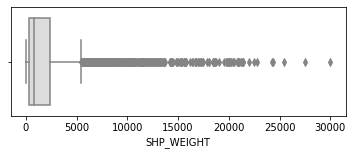

In [63]:
plt.figure(figsize=(6,2))
seaborn.boxplot(x="SHP_WEIGHT", data=df, palette="coolwarm")

#### Coeficientes de asimetría y kurtosis

In [73]:
ku = sc.stats.kurtosis(df["SHP_WEIGHT"])
print('Kurtosis de SHP_WEIGHT: {}'.format(ku))
sw = sc.stats.skew(df["SHP_WEIGHT"])
print('Swewness de SHP_WEIGHT: {}'.format(sw))

Kurtosis de SHP_WEIGHT: 11.246786891708675
Swewness de SHP_WEIGHT: 3.0763302160747377


#### Histograma

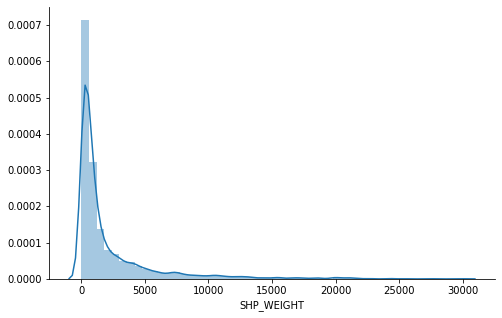

In [65]:
plt.figure(figsize=(8, 5))
seaborn.distplot(df['SHP_WEIGHT'], label='SHP_WEIGHT')
seaborn.despine()

#### Outliers

In [66]:
q1=df["SHP_WEIGHT"].quantile(0.25)
q3=df["SHP_WEIGHT"].quantile(0.75)

LSO = q3 + 1.5 * (q3-q1)
df["SHP_WEIGHT"][df["SHP_WEIGHT"]>LSO]

1        6100.0
14      18600.0
20      22000.0
33      10500.0
53      10870.0
         ...   
3312     7440.0
3326    12205.0
3330    10500.0
3338    11700.0
3343    15800.0
Name: SHP_WEIGHT, Length: 375, dtype: float64

#### Histograma de los outliers

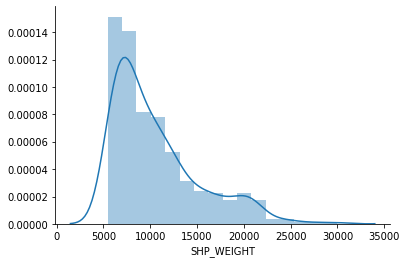

In [72]:
seaborn.distplot(df["SHP_WEIGHT"][df["SHP_WEIGHT"]>LSO])
seaborn.despine()

#### Histograma sin outliers

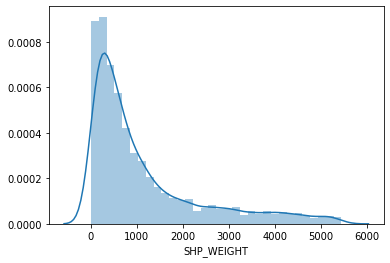

In [68]:
seaborn.distplot(df["SHP_WEIGHT"][df["SHP_WEIGHT"]<=LSO])
seaborn.despine()

#### Histograma del logaritmo natural

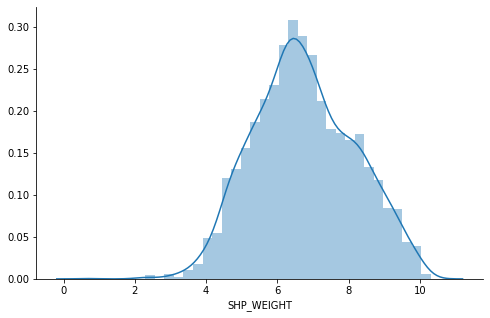

In [71]:
plt.figure(figsize=(8, 5))
seaborn.distplot(np.log(df['SHP_WEIGHT']))
seaborn.despine()

Como el histograma sin outliers aparenta tener nuevamente outliers se aprecia que mas que un probelma de outliers se tienen un problema de distribución de tipo exponencial. Al tomar logaritmo natural se obtiene una distribución bastente bien comportada. En vez de remover outliers conviene transformar la variable tomando su logaritmo natural.

### `SHP_VOLUME`

#### Medidas descriptivas

In [74]:
df['SHP_VOLUME'].describe()

count      3348.000000
mean      16510.719932
std       31162.406731
min           0.000000
25%        2200.000000
50%        5279.000000
75%       15666.000000
max      395280.000000
Name: SHP_VOLUME, dtype: float64

#### Boxplot

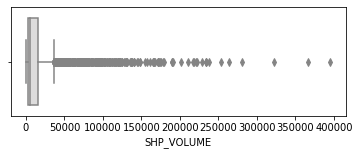

In [75]:
plt.figure(figsize=(6,2))
seaborn.boxplot(x="SHP_VOLUME", data=df, palette="coolwarm")

#### Coeficientes de asimetría y kurtosis

In [76]:
ku = sc.stats.kurtosis(df["SHP_VOLUME"])
print('Kurtosis de SHP_VOLUME: {}'.format(ku))
sw = sc.stats.skew(df["SHP_VOLUME"])
print('Swewness de SHP_VOLUME: {}'.format(sw))

Kurtosis de SHP_VOLUME: 28.238870575254108
Swewness de SHP_VOLUME: 4.436552504856737


#### Histograma

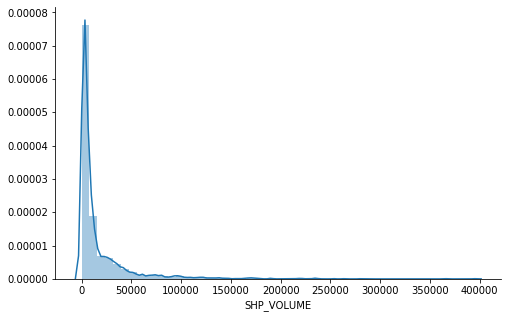

In [77]:
plt.figure(figsize=(8, 5))
seaborn.distplot(df['SHP_VOLUME'], label='SHP_VOLUME')
seaborn.despine()

#### Outliers

In [78]:
q1=df["SHP_VOLUME"].quantile(0.25)
q3=df["SHP_VOLUME"].quantile(0.75)

LSO = q3 + 1.5 * (q3-q1)
df["SHP_VOLUME"][df["SHP_VOLUME"]>LSO]

6        47068.0
20      234300.0
32       38880.0
33       89544.0
42       97680.0
          ...   
3327     36450.0
3329     59644.0
3331    137270.0
3341     42840.0
3343    216381.0
Name: SHP_VOLUME, Length: 412, dtype: float64

#### Histograma de los outliers

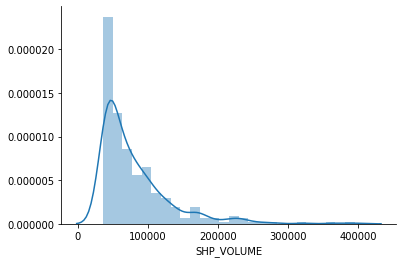

In [79]:
seaborn.distplot(df["SHP_VOLUME"][df["SHP_VOLUME"]>LSO])
seaborn.despine()

#### Histograma sin outliers

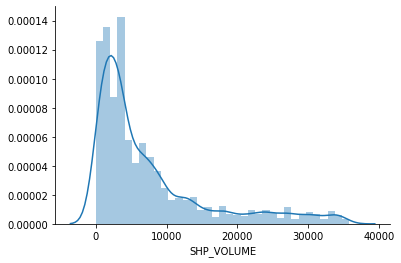

In [80]:
seaborn.distplot(df["SHP_VOLUME"][df["SHP_VOLUME"]<=LSO])
seaborn.despine()

In [89]:
df['SHP_VOLUME'][df["SHP_VOLUME"] >0]

0        10000.0
1         8750.0
2         2200.0
3         6875.0
4        18564.0
          ...   
3343    216381.0
3344      3125.0
3345      8000.0
3346     11232.0
3347      4032.0
Name: SHP_VOLUME, Length: 3258, dtype: float64

In [83]:
len(df['SHP_VOLUME'].index)

3348

In [87]:
df['SHP_VOLUME'][df["SHP_VOLUME"] ==0]

28      0.0
69      0.0
95      0.0
157     0.0
200     0.0
       ... 
3175    0.0
3286    0.0
3313    0.0
3314    0.0
3321    0.0
Name: SHP_VOLUME, Length: 90, dtype: float64

In [88]:
df['SHP_VOLUME'][df["SHP_VOLUME"] <0]

Series([], Name: SHP_VOLUME, dtype: float64)

#### Histograma del logaritmo natural

En este caso, dado que la variable asume algunos valores nulos se produce un error al tomar logaritmos. Dado que ese problema se da en relativamente pocos valores, se opta por trabajar con el logaritmo natural de los valores no nulos de la variable.

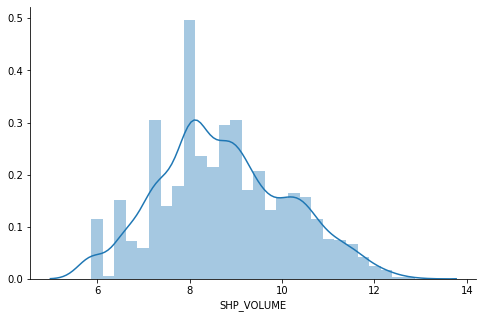

In [90]:
plt.figure(figsize=(8, 5))
seaborn.distplot(np.log(df['SHP_VOLUME'][df["SHP_VOLUME"] >0]))
seaborn.despine()

Como el histograma sin outliers aparenta tener nuevamente outliers se aprecia que mas que un probelma de outliers se tienen un problema de distribución de tipo exponencial. Al tomar logaritmo natural se obtiene una distribución bastente bien comportada. En vez de remover outliers conviene transformar la variable tomando su logaritmo natural.